# Dataset Description
In a PUBG game, up to 100 players start in each match (matchId). Players can be on teams (groupId) which get ranked at the end of the game (winPlacePerc) based on how many other teams are still alive when they are eliminated. In game, players can pick up different munitions, revive downed-but-not-out (knocked) teammates, drive vehicles, swim, run, shoot, and experience all of the consequences -- such as falling too far or running themselves over and eliminating themselves.

You are provided with a large number of anonymized PUBG game stats, formatted so that each row contains one player's post-game stats. The data comes from matches of all types: solos, duos, squads, and custom; there is no guarantee of there being 100 players per match, nor at most 4 player per group.

You must create a model which predicts players' finishing placement based on their final stats, on a scale from 1 (first place) to 0 (last place).

# Data fields
- `DBNOs` - Number of enemy players knocked.
- `assists` - Number of enemy players this player damaged that were killed by teammates.
- `boosts` - Number of boost items used.(Energy Drink, Painkillers, Adrenaline Syringe)
- `damageDealt` - Total damage dealt. Note: Self inflicted damage is subtracted.
- `headshotKills` - Number of enemy players killed with headshots.
- `heals` - Number of healing items used.
- `Id` - Player’s Id
- `killPlace` - Ranking in match of number of enemy players killed.
- `killPoints` - Kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter.) If there is a value other than -1 in rankPoints, then any 0 in killPoints should be treated as a “None”.
- `killStreaks` - Max number of enemy players killed in a short amount of time.
- `kills` - Number of enemy players killed.
- `longestKill` - Longest distance between player and player killed at time of death. This may be misleading, as downing a player and driving away may lead to a large longestKill stat.
- `matchDuration` - Duration of match in seconds.
- `matchId` - ID to identify match. There are no matches that are in both the training and testing set.
- `matchType` - String identifying the game mode that the data comes from. The standard modes are “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp”, and “squad-fpp”; other modes are from events or custom matches.
- `rankPoints` - Elo-like ranking of player. This ranking is inconsistent and is being deprecated in the API’s next version, so use with caution. Value of -1 takes place of “None”.
- `revives` - Number of times this player revived teammates.
- `rideDistance` - Total distance traveled in vehicles measured in meters.
- `roadKills` - Number of kills while in a vehicle.
- `swimDistance` - Total distance traveled by swimming measured in meters.
- `teamKills` - Number of times this player killed a teammate.
- `vehicleDestroys` - Number of vehicles destroyed.
- `walkDistance` - Total distance traveled on foot measured in meters.
- `weaponsAcquired` - Number of weapons picked up.
- `winPoints` - Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.) If there is a value other than -1 in rankPoints, then any 0 in winPoints should be treated as a “None”.
- `groupId` - ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.
- `numGroups` - Number of groups we have data for in the match.
- `maxPlace` - Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.
- `winPlacePerc` - The target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match.

# We'll follow a step-by-step process:
1. Download and prepare the dataset for training
2. Train, evaluate and interpret a decision tree
3. Train, evaluate and interpret a random forest
4. Tune hyperparameters to improve the model
5. Make predictions and save the model

# Importing libraries


In [1]:
!pip install opendatasets

You should consider upgrading via the 'C:\Users\Mohit Bhilwara\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import opendatasets as od


In [3]:
# import opendatasets as od

# Downloading Dataset from kaggle

In [4]:
data_url = 'https://www.kaggle.com/competitions/pubg-finish-placement-prediction'
od.download(data_url)

Skipping, found downloaded files in ".\pubg-finish-placement-prediction" (use force=True to force download)


In [5]:
raw_df = pd.read_csv('pubg-finish-placement-prediction/train_V2.csv')

In [6]:
raw_df.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


In [7]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int64  
 4   boosts           int64  
 5   damageDealt      float64
 6   DBNOs            int64  
 7   headshotKills    int64  
 8   heals            int64  
 9   killPlace        int64  
 10  killPoints       int64  
 11  kills            int64  
 12  killStreaks      int64  
 13  longestKill      float64
 14  matchDuration    int64  
 15  matchType        object 
 16  maxPlace         int64  
 17  numGroups        int64  
 18  rankPoints       int64  
 19  revives          int64  
 20  rideDistance     float64
 21  roadKills        int64  
 22  swimDistance     float64
 23  teamKills        int64  
 24  vehicleDestroys  int64  
 25  walkDistance     float64
 26  weaponsAcquired  int64  
 27  winPoints   

In [8]:
raw_df.winPlacePerc.mean()

0.47282155272191256

In [9]:
raw_df.isna().sum()

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       1
dtype: int64

In [10]:
raw_df['winPlacePerc'] = raw_df['winPlacePerc'].fillna(0.4728)

In [11]:
# raw_df.isna().sum()

# visualization

In [12]:
match_type = raw_df.matchType.value_counts()
match_type

squad-fpp           1756186
duo-fpp              996691
squad                626526
solo-fpp             536762
duo                  313591
solo                 181943
normal-squad-fpp      17174
crashfpp               6287
normal-duo-fpp         5489
flaretpp               2505
normal-solo-fpp        1682
flarefpp                718
normal-squad            516
crashtpp                371
normal-solo             326
normal-duo              199
Name: matchType, dtype: int64

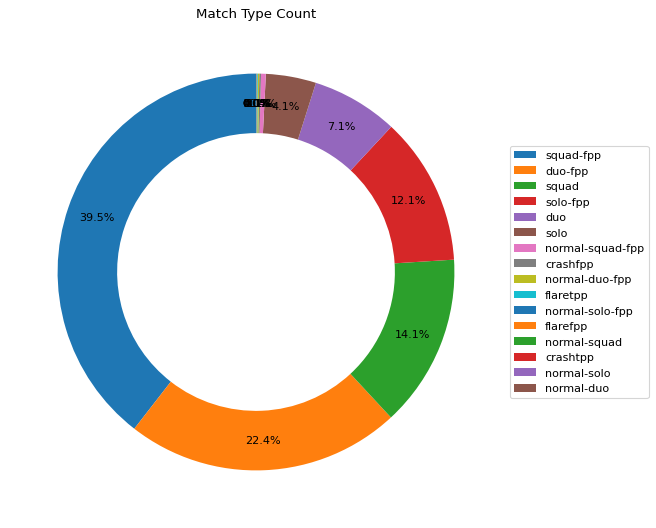

In [13]:
plt.figure(figsize = (8,16),dpi = 80)
plt.title("Match Type Count")
plt.pie(match_type,wedgeprops={'width':0.3}, 
       startangle=90,autopct = '%1.1f%%',pctdistance=0.85)
plt.legend(match_type.index,loc = 'center left' ,bbox_to_anchor=(1,0.5));

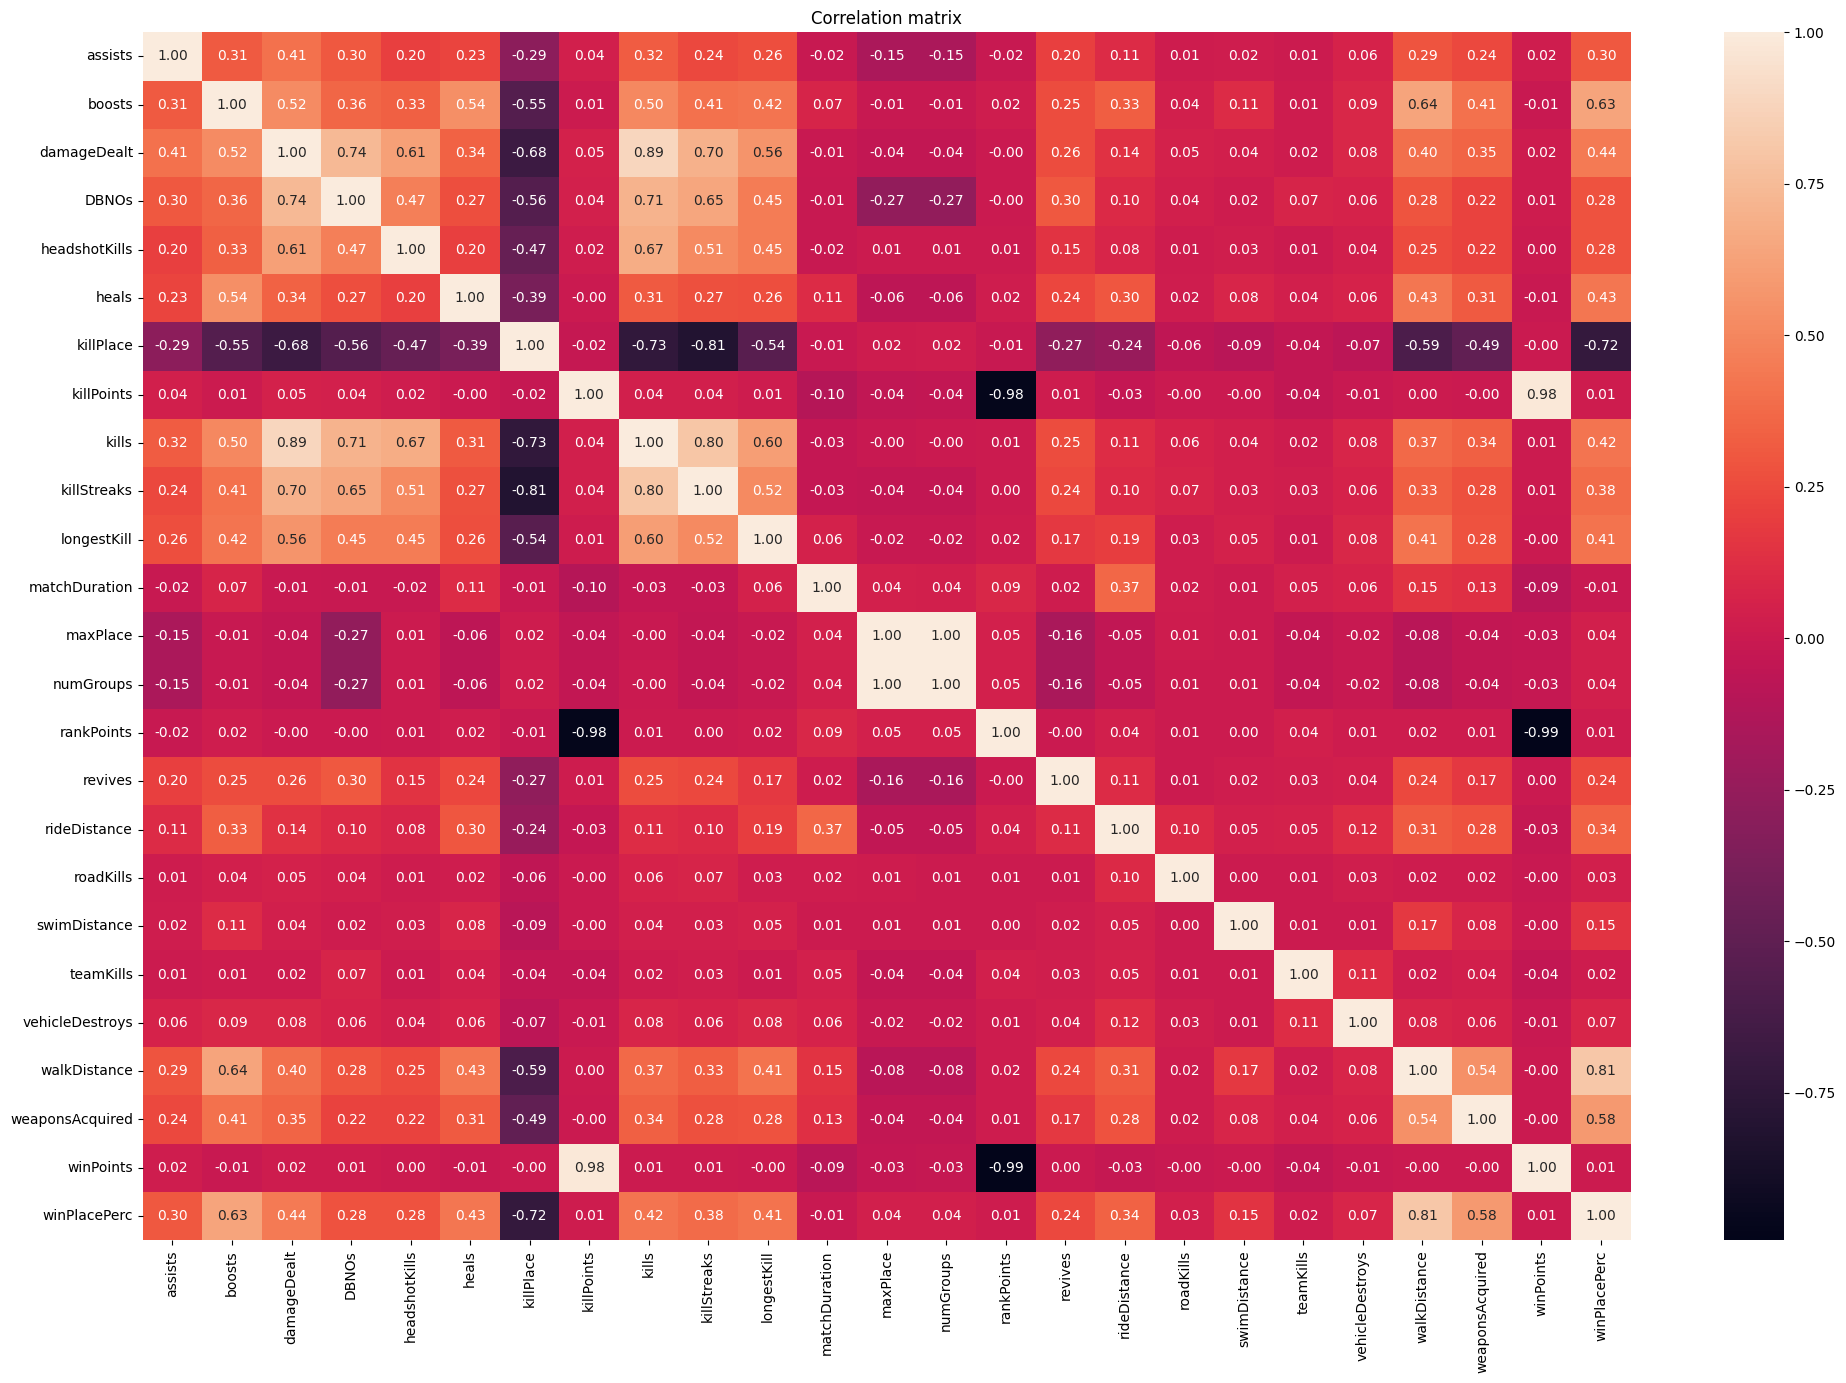

In [14]:
plt.figure(figsize= (24,16),dpi =100)
plt.title('Correlation matrix')
sns.heatmap(raw_df.corr(),annot = True, fmt=".2f");

In [15]:
sample= raw_df.sample(440000)

In [16]:
# plt.figure(figsize =(12,8),dpi = 80)
# plt.title('Relation between walkDistance and winPlacePerc')
# plt.xlabel('WalkDistance')
# plt.ylabel('WinPlacePerc')
# sns.lineplot(x=sample['walkDistance'],y=sample['winPlacePerc']);

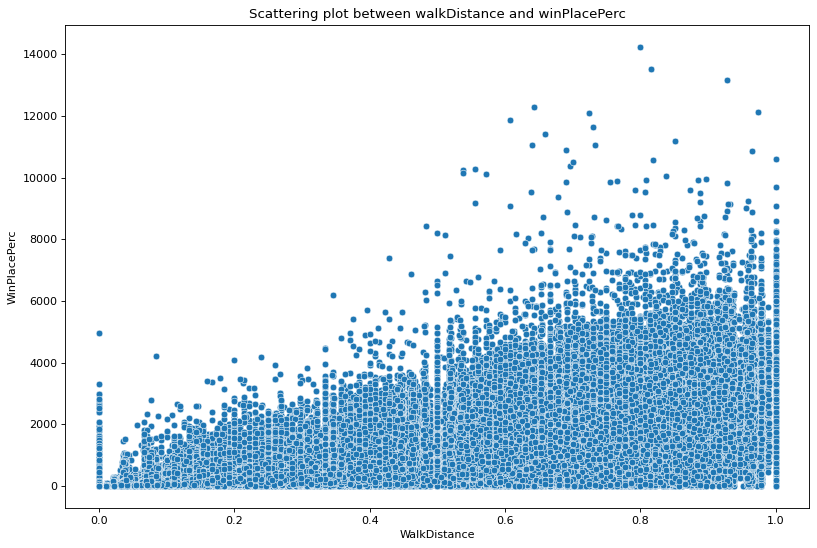

In [17]:
plt.figure(figsize =(12,8),dpi = 80)
plt.title('Scattering plot between walkDistance and winPlacePerc')
plt.xlabel('WalkDistance')
plt.ylabel('WinPlacePerc')
sns.scatterplot(data = sample , y= 'walkDistance',x = 'winPlacePerc');

In [18]:
sample = sample.sort_values(by =['kills'])
sample

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
2791133,c6309d20e62d08,355901b0e77c21,4349d5bf357c51,0,0,42.85,0,0,0,73,...,0,0.0,0,0.00,0,0,502.80,3,0,0.2526
1315526,abd81fe7ff7887,25fb983a6839ec,6faaa8ec42aa85,1,0,26.98,0,0,0,77,...,0,0.0,0,0.00,0,0,210.00,3,1476,0.1778
4110383,8c95fc06c010fb,f9c871ca6ff1a7,059ad462cba66a,0,0,101.90,1,0,0,77,...,0,0.0,0,0.00,0,0,135.40,3,0,0.2083
767515,de306958050add,0a4c8692721ba3,d63516ca90d315,0,0,0.00,0,0,0,61,...,0,0.0,0,0.00,0,0,491.30,1,0,0.3587
1264750,3387a72fbd6821,4de19c60516bf7,03f9d7128bbd6d,0,0,0.00,0,0,0,49,...,0,0.0,0,17.39,0,0,1290.00,2,0,0.6364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3415833,410a3acdefa560,6dcd8c5ad01853,313c9787226bbe,5,0,4238.00,33,6,7,1,...,2,0.0,0,0.00,0,0,827.90,20,0,0.6667
2316123,dbc81aa64a7e3d,c50fe5c54e8bb6,5d58307bae9b50,8,0,4106.00,31,3,0,1,...,0,0.0,0,0.00,0,0,1282.00,22,0,1.0000
3673965,f83f0bfaafb7d8,22d80bf00f56b7,fc0bbecba8db99,2,1,5330.00,53,41,21,1,...,0,0.0,0,0.00,0,0,12.19,17,1500,1.0000
1491277,1f6ceaa5140fb6,dc2fef63e14d5c,f900de1ec39fa5,15,0,5468.00,0,13,5,2,...,0,3492.0,0,0.00,0,0,1059.00,60,0,0.9000


C:\Users\Mohit Bhilwara\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


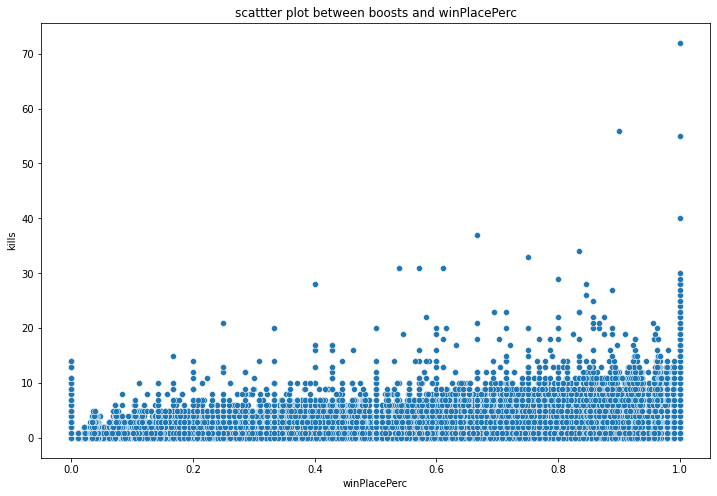

In [19]:
plt.figure(figsize=(12,8))
plt.title('scattter plot between boosts and winPlacePerc')
plt.xlabel('winPlacePerc')
plt.ylabel('kills')
sns.scatterplot(sample.winPlacePerc,sample.kills);

In [20]:
sample= sample.sort_values(by=['weaponsAcquired'])

C:\Users\Mohit Bhilwara\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


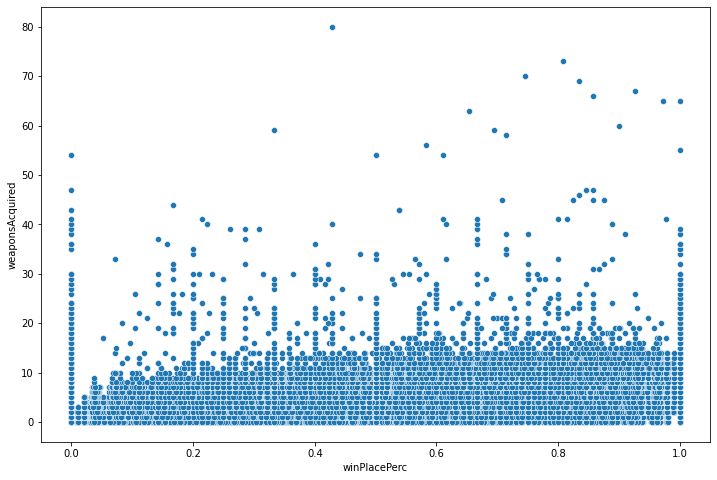

In [21]:
plt.figure(figsize=(12,8))
plt.xlabel('winPlacePerc')
plt.ylabel('weaponsAcquired')
sns.scatterplot(sample.winPlacePerc,sample.weaponsAcquired);

C:\Users\Mohit Bhilwara\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


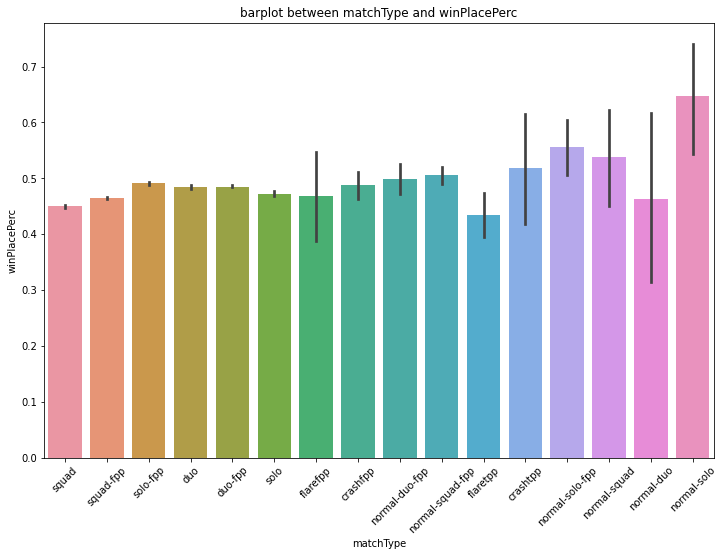

In [22]:
plt.figure(figsize=(12,8))
plt.title('barplot between matchType and winPlacePerc')
plt.xlabel('MatchType')
plt.ylabel('WinPlacePerc')
plt.xticks(rotation = 45)
sns.barplot(sample.matchType,sample.winPlacePerc);

C:\Users\Mohit Bhilwara\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


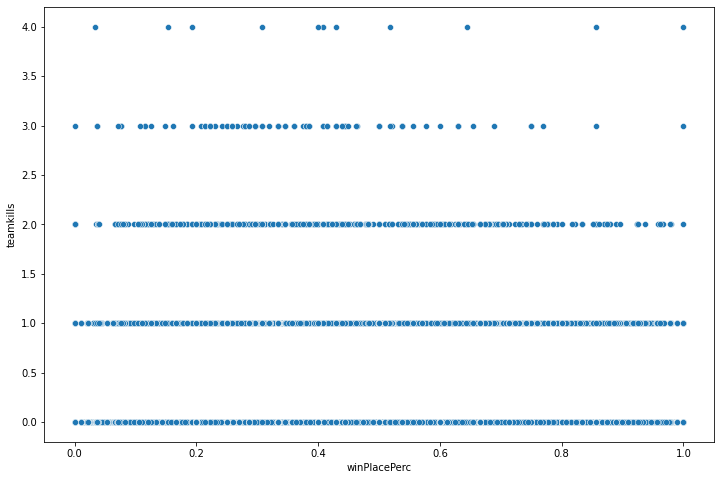

In [23]:
plt.figure(figsize =(12,8))
plt.xlabel('winPlacePerc')
plt.ylabel('teamkills')
sns.scatterplot(sample.winPlacePerc,sample.teamKills);

In [24]:
headshot = sample.groupby(['headshotKills']).mean()
headshot

,assists,boosts,damageDealt,DBNOs,heals,killPlace,killPoints,kills,killStreaks,longestKill,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
headshotKills,,,,,,,,,,,,,,,,,,,,,
0,0.185449,0.864933,90.851916,0.441402,1.122886,54.064583,498.250995,0.521810,0.370778,13.488396,...,0.133736,558.009421,0.003185,4.113994,0.023221,0.006349,1020.953343,3.443069,604.992962,0.433777
1,0.400998,2.004516,267.793357,1.447814,2.316135,18.884232,530.259036,2.305957,1.300947,58.460693,...,0.294068,781.381077,0.005451,5.953348,0.029193,0.012665,1655.907754,4.510063,610.646046,0.626587
2,0.600977,3.042330,439.617056,2.322876,3.184219,8.068895,551.202901,4.046508,1.621630,92.572352,...,0.412738,971.980482,0.005991,6.990488,0.029245,0.019234,2160.437788,5.207394,613.516711,0.751881
3,0.786028,3.828321,617.372118,3.114035,3.661028,4.004386,577.593985,5.838033,1.833020,122.300986,...,0.482143,1108.226236,0.006579,8.216252,0.018484,0.022870,2484.944377,5.840226,625.650063,0.832465
4,0.861937,4.470757,788.800959,3.720997,4.110259,2.545542,580.476510,7.515820,1.992330,147.580093,...,0.501438,1285.990307,0.009588,10.451590,0.021093,0.027804,2679.906261,6.467881,624.398849,0.877519
5,1.111111,4.719136,1005.677469,4.543210,3.660494,1.938272,625.398148,9.314815,2.197531,187.810836,...,0.487654,1264.139856,0.006173,12.501420,0.037037,0.030864,2727.817377,7.157407,691.595679,0.903075
6,1.293706,4.538462,1149.872028,5.314685,3.923077,2.083916,654.867133,11.146853,2.342657,203.115063,...,0.426573,1198.156909,0.020979,13.396629,0.020979,0.027972,2578.048881,8.895105,740.230769,0.899443
7,1.268657,4.298507,1287.653731,6.567164,3.149254,1.925373,771.268657,12.074627,2.746269,183.846522,...,0.567164,1308.124082,0.000000,3.414448,0.014925,0.014925,2558.304328,9.104478,850.910448,0.898091
8,1.558824,3.764706,1487.982353,6.941176,3.000000,1.617647,529.000000,13.352941,2.705882,238.106176,...,0.470588,927.491176,0.000000,9.585471,0.029412,0.000000,2439.952941,10.294118,627.882353,0.856062


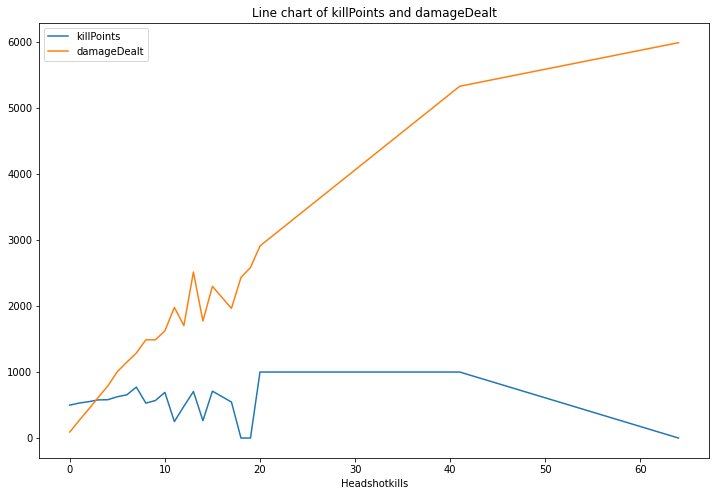

In [25]:
plt.figure(figsize = (12,8))
plt.title('Line chart of killPoints and damageDealt')
plt.plot(headshot.index,headshot.killPoints)
plt.plot(headshot.index,headshot.damageDealt)
plt.xlabel('Headshotkills')
plt.legend(['killPoints','damageDealt']);

# Data Preprocessing 
Before we can train the model, we need to prepare the dataset. Here are the steps we'll follow:

1. Identify the input and target column(s) for training the model.
2. Identify numeric and categorical input columns.
3. Impute (fill) missing values in numeric columns (becuase in this dataset there is no missing values.)
4. Scale values in numeric columns to a (0,1)range.
5. Encode categorical data into one-hot vectors.
6. Split the dataset into training and validation sets.

## Because dataset is so big to process faster we'll take 10% sample rows from the dataset.

In [26]:
raw_df = raw_df.sample(440000)

In [27]:
raw_df.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
2773129,d7f9512177ba11,348a3abfd8cdd2,d10366c6c9109f,0,0,212.70,1,0,0,72,...,0,0.0,0,0.0,0,0,110.9,2,0,0.2222
774688,7695e985baeba8,9974f18e2f0338,227bf5a7de817e,1,0,35.97,0,0,0,71,...,0,951.8,0,0.0,0,0,155.6,1,0,0.3958
679052,00a67ce44ddf0e,f7102953f432ff,b02f9f8b1cfbf1,1,6,491.20,3,2,4,4,...,0,0.0,0,0.0,0,0,2984.0,4,1500,0.9630
3674181,a3d2bc180eea31,1f97b1407fa872,3f525d8ff80d23,0,4,183.50,1,0,7,21,...,1,1185.0,0,0.0,0,0,3397.0,6,1498,0.8148
1557521,f7beb82030e159,9a0568b9af61da,c61d0f27d267b3,1,0,75.67,1,0,1,40,...,1,0.0,0,0.0,0,0,274.7,3,0,0.3077


# Identify Inputs and Targets
While the dataset contains many columns, not all of them are useful for modeling. Note the following:

- The first column Id is a unique ID for each player and isn't useful for training the model.
- The last column winPlacePerc contains the value we need to predict i.e. it's the target column.
- Data from all the other columns (except the first three and the last column) can be used as inputs to the model.

In [28]:
col_list = raw_df.columns.tolist()

In [29]:
col_list

['Id',
 'groupId',
 'matchId',
 'assists',
 'boosts',
 'damageDealt',
 'DBNOs',
 'headshotKills',
 'heals',
 'killPlace',
 'killPoints',
 'kills',
 'killStreaks',
 'longestKill',
 'matchDuration',
 'matchType',
 'maxPlace',
 'numGroups',
 'rankPoints',
 'revives',
 'rideDistance',
 'roadKills',
 'swimDistance',
 'teamKills',
 'vehicleDestroys',
 'walkDistance',
 'weaponsAcquired',
 'winPoints',
 'winPlacePerc']

In [30]:
Id = raw_df.columns[0:3]

In [31]:
Id = list(Id)

In [32]:
inputs_col = raw_df.columns[3:-1]
inputs_col = list(inputs_col)


In [33]:
inputs_df = raw_df[inputs_col].copy()

In [34]:
target_df= raw_df[['winPlacePerc']]
target_df 

,winPlacePerc
2773129,0.2222
774688,0.3958
679052,0.9630
3674181,0.8148
1557521,0.3077
...,...
2382001,0.0370
2467333,0.7526
2650032,0.2000
1239876,0.9072


In [35]:
target = target_df.copy()
target.head()

,winPlacePerc
2773129,0.2222
774688,0.3958
679052,0.9630
3674181,0.8148
1557521,0.3077


In [36]:
# raw_df[Id+inputs_col]

## sperating numeric columns and catagorical columns from inputs
The next step in data preparation is to identify numeric and categorical columns. We can do this by looking at the data type of each column.

In [37]:
numerical_col = raw_df[inputs_col].select_dtypes(include = np.number).columns.tolist()

In [38]:
catagorical_col = raw_df[inputs_col].select_dtypes('object').columns.tolist()

In [39]:
print('numerical columns :',numerical_col)
print('catagoiracl columns :',catagorical_col)

numerical columns : ['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills', 'killStreaks', 'longestKill', 'matchDuration', 'maxPlace', 'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills', 'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance', 'weaponsAcquired', 'winPoints']
catagoiracl columns : ['matchType']


# Scale Numeric values
A good practice is to scale numeric features to a small range of values e.g. (0,1). Scaling numeric features ensures that no particular feature has a disproportionate impact on the model's loss. Optimization algorithms also work better in practice with smaller numbers

In [40]:
from sklearn.preprocessing import MinMaxScaler

In [41]:
scaler = MinMaxScaler().fit(raw_df[numerical_col])

In [42]:
raw_df[numerical_col] = scaler.transform(raw_df[numerical_col])

In [43]:
raw_df.sample(10)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
4326385,ff7ea9d296b576,f3aaba57f43a6d,97c8594c6ab527,0.0,0.00,0.007686,0.000000,0.000000,0.000000,0.838384,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.002339,0.039474,0.000000,0.0435
1812903,b551f1962fd252,472f323a0155bc,7e30c82419d43f,0.0,0.00,0.008455,0.000000,0.000000,0.000000,0.919192,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.001095,0.026316,0.723862,0.0345
1773556,d5da96f7e6aaf8,0729c18424cccb,283b328969f368,0.2,0.05,0.038651,0.000000,0.043478,0.037037,0.131313,...,0.043478,0.034132,0.0,0.000000,0.0,0.0,0.124903,0.092105,0.759380,0.6957
618924,b8aad98819392e,786206fc265bbc,eb0b7ba76b1ea0,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.757576,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.004725,0.013158,0.000000,0.1667
3775744,f9bca076ecfcbc,91aa90680a61b3,aa516e44e584ab,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.919192,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000293,0.013158,0.000000,0.0521
1157242,7a7372f5087c61,dc16f44bc49fd2,9244c633cb99f4,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.666667,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.005423,0.013158,0.000000,0.2581
2461494,d47728029fbd04,99e68e661639d0,edf94392dc8594,0.0,0.05,0.031373,0.000000,0.000000,0.018519,0.212121,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.004077,0.026316,0.709355,0.3535
4275608,55e3ba66642c3f,b39368bb729a1e,7e7d1a3668c1bf,0.0,0.00,0.015120,0.000000,0.000000,0.000000,0.949495,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000897,0.013158,0.000000,0.0000
2247287,e2ffc4c6b246b5,e2df8de59cb61c,deb7a70363cde2,0.0,0.15,0.016784,0.026316,0.000000,0.018519,0.454545,...,0.130435,0.000000,0.0,0.025458,0.0,0.0,0.089372,0.052632,0.000000,0.8519
435013,0fe1363c523808,69e94dd0f55022,6d8dd6089da68c,0.0,0.00,0.017835,0.000000,0.000000,0.000000,0.848485,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.004725,0.039474,0.759380,0.0741


# Encode catagorical columns
Since machine learning models can only be trained with numeric data, we need to convert categorical data to numbers. A common technique is to use one-hot encoding for categorical columns.

In [44]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

In [45]:
encoder = OneHotEncoder(sparse = False , handle_unknown= 'ignore').fit(raw_df[catagorical_col])
encoded_col =  list(encoder.get_feature_names_out(catagorical_col))
raw_df[encoded_col] = encoder.transform(raw_df[catagorical_col])

C:\Users\Mohit Bhilwara\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [46]:
len(encoded_col)

16

In [47]:
raw_df.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,matchType_normal-duo,matchType_normal-duo-fpp,matchType_normal-solo,matchType_normal-solo-fpp,matchType_normal-squad,matchType_normal-squad-fpp,matchType_solo,matchType_solo-fpp,matchType_squad,matchType_squad-fpp
2773129,d7f9512177ba11,348a3abfd8cdd2,d10366c6c9109f,0.000000,0.0,0.033365,0.026316,0.000000,0.000000,0.717172,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
774688,7695e985baeba8,9974f18e2f0338,227bf5a7de817e,0.066667,0.0,0.005642,0.000000,0.000000,0.000000,0.707071,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
679052,00a67ce44ddf0e,f7102953f432ff,b02f9f8b1cfbf1,0.066667,0.3,0.077051,0.078947,0.086957,0.074074,0.030303,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3674181,a3d2bc180eea31,1f97b1407fa872,3f525d8ff80d23,0.000000,0.2,0.028784,0.026316,0.000000,0.129630,0.202020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1557521,f7beb82030e159,9a0568b9af61da,c61d0f27d267b3,0.066667,0.0,0.011870,0.026316,0.000000,0.018519,0.393939,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## creating Training and Validation sets.
Finally, let's split the dataset into a training and validation set. We'll use a randomly select 25% subset of the data for validation. Also, we'll use just the numeric and encoded columns, since the inputs to our model must be numbers.

In [48]:
from sklearn.model_selection import train_test_split

In [49]:
train_inputs ,val_inputs,train_target ,val_target = train_test_split(raw_df[numerical_col+encoded_col], target, test_size = 0.25,random_state = 42)

In [50]:
train_inputs.head()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,...,matchType_normal-duo,matchType_normal-duo-fpp,matchType_normal-solo,matchType_normal-solo-fpp,matchType_normal-squad,matchType_normal-squad-fpp,matchType_solo,matchType_solo-fpp,matchType_squad,matchType_squad-fpp
2574894,0.0,0.00,0.000000,0.000000,0.0,0.000000,0.484848,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
869604,0.0,0.05,0.045349,0.078947,0.0,0.018519,0.212121,0.000000,0.015152,0.055556,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2109613,0.0,0.00,0.000000,0.000000,0.0,0.000000,0.898990,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2145536,0.0,0.10,0.039922,0.026316,0.0,0.111111,0.494949,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
663633,0.0,0.00,0.020000,0.026316,0.0,0.000000,0.666667,0.554618,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
train_target.head()

,winPlacePerc
2574894,0.9286
869604,0.5417
2109613,0.0213
2145536,0.6333
663633,0.3265


In [52]:
val_inputs.head()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,...,matchType_normal-duo,matchType_normal-duo-fpp,matchType_normal-solo,matchType_normal-solo-fpp,matchType_normal-squad,matchType_normal-squad-fpp,matchType_solo,matchType_solo-fpp,matchType_squad,matchType_squad-fpp
663389,0.0,0.00,0.009315,0.000000,0.000000,0.000000,0.727273,0.633380,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
144299,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.777778,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
305011,0.0,0.35,0.002376,0.000000,0.000000,0.018519,0.393939,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4255016,0.0,0.00,0.019184,0.000000,0.000000,0.000000,0.585859,0.570558,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4435593,0.0,0.15,0.047216,0.052632,0.043478,0.148148,0.070707,0.000000,0.045455,0.111111,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
val_target.sample(10)

,winPlacePerc
1847790,0.8980
4395641,0.1111
4436259,0.6296
3092529,0.6071
3705166,0.3370
2309443,0.5158
1536191,0.7600
719084,0.6786
3860695,0.9167
2941715,0.5556


In [54]:
# X_train = train_inputs.drop(['Id','groupId','matchId'],axis = 1)

In [55]:
# X_val = val_inputs.drop(['Id','groupId','matchId'],axis = 1)

In [56]:
# X_train

In [57]:
# X_val.head()

# Decision Tree Model

In [58]:
from sklearn.tree import DecisionTreeRegressor

In [59]:
model_decision = DecisionTreeRegressor(random_state = 42)

In [60]:
model_decision.fit(train_inputs,train_target)

DecisionTreeRegressor(random_state=42)

In [61]:
from sklearn.metrics import mean_squared_error

In [62]:
def rmse(pred,target):
    return mean_squared_error(pred,target,squared = False)

In [63]:
train_pred = model_decision.predict(train_inputs)
train_pred

array([0.9286, 0.5417, 0.0213, ..., 0.7586, 0.6531, 0.8148])

In [64]:
val_pred = model_decision.predict(val_inputs)
val_pred

array([0.3333, 0.0833, 0.9259, ..., 0.0208, 0.25  , 0.931 ])

In [65]:
print('Training error',rmse(train_pred,train_target))

Training error 3.850502385100256e-18


In [66]:
print('Validaiont error:',rmse(val_pred,val_target))

Validaiont error: 0.12060557044914483


In [67]:
decision_error = (rmse(train_pred,train_target),rmse(val_pred,val_target))

In [68]:
decision_error

(3.850502385100256e-18, 0.12060557044914483)

# Linear Regression Model

In [69]:
# from sklearn.linear_model import LinearRegression

In [70]:
# model_linear= LinearRegression()
# model_linear.fit(train_inputs,train_target)

In [71]:
# train_pred_linear = model_linear.predict(train_inputs)

In [72]:
# val_pred_linear = model_linear.predict(val_inputs)

In [73]:
# print('Linear Model training error:',rmse(train_pred_linear,train_target))

In [74]:
# print('Linear Model validation error:',rmse(val_pred_linear,val_target))

In [75]:
# linear_error = (rmse(train_pred_linear,train_target),rmse(val_pred_linear,val_target))

In [76]:
# linear_error

# Random Forest Model

In [77]:
from sklearn.ensemble import RandomForestRegressor

In [78]:
model_random = RandomForestRegressor(random_state = 42,n_jobs =-1,n_estimators = 10)

In [79]:
%%time
model_random.fit(train_inputs,train_target)

<timed eval>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


CPU times: total: 2min 14s
Wall time: 46.6 s


RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=42)

In [80]:
train_pred_random =model_random.predict(train_inputs)
val_pred_random = model_random.predict(val_inputs)

In [81]:
print('Random Forest Model training error :',rmse(train_pred_random,train_target))
print('Random Forest Model validation error',rmse(val_pred_random,val_target))

Random Forest Model training error : 0.037909774781402575
Random Forest Model validation error 0.08940288299508428


In [82]:
random_error = (rmse(train_pred_random,train_target),rmse(val_pred_random,val_target))

In [83]:
random_error

(0.037909774781402575, 0.08940288299508428)

# Hypreparameter tuning of Random Forest.

Let us now tune the hyperparameters of our model. You can find the hyperparameters for `RandomForestRegressor` here: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

<img src="https://i.imgur.com/EJCrSZw.png" width="480">

Hyperparameters are use

In [84]:
def n_estimators(n):
  model = RandomForestRegressor(random_state = 42,n_jobs = -1 , n_estimators = n).fit(train_inputs,train_target)
  train_err = rmse(model.predict(train_inputs),train_target)
  val_err = rmse(model.predict(val_inputs),val_target)
  return {'Estimator':n,'Train_error':train_err,'Validation_error':val_err} 

In [85]:
error_df = pd.DataFrame([n_estimators(n) for n in range(10,100,10)])

C:\Users\Mohit Bhilwara\AppData\Local\Temp\ipykernel_1000\424520011.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = RandomForestRegressor(random_state = 42,n_jobs = -1 , n_estimators = n).fit(train_inputs,train_target)
C:\Users\Mohit Bhilwara\AppData\Local\Temp\ipykernel_1000\424520011.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = RandomForestRegressor(random_state = 42,n_jobs = -1 , n_estimators = n).fit(train_inputs,train_target)
C:\Users\Mohit Bhilwara\AppData\Local\Temp\ipykernel_1000\424520011.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = RandomForestRegressor(random_state = 42,n_jobs = -1 , n_estimators = n).fit(t

In [86]:
error_df

,Estimator,Train_error,Validation_error
0,10,0.037910,0.089403
1,20,0.034711,0.087042
2,30,0.033566,0.086333
3,40,0.032984,0.085947
4,50,0.032641,0.085743
5,60,0.032429,0.085615
6,70,0.032260,0.085482
7,80,0.032146,0.085427
8,90,0.032051,0.085381


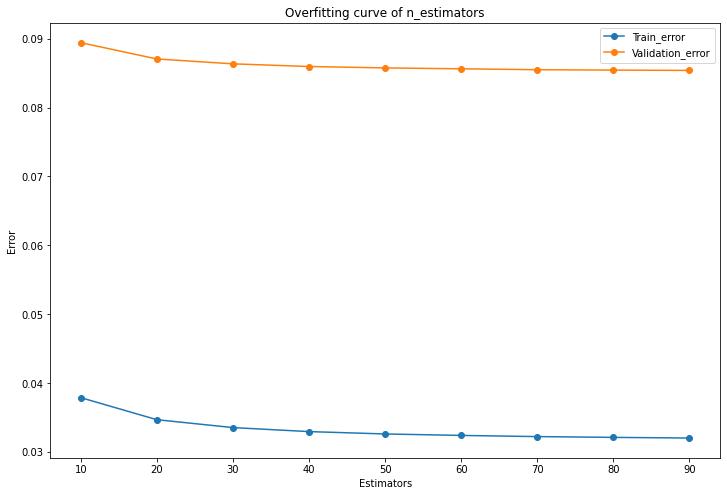

In [122]:
plt.figure(figsize=(12,8))
plt.plot(error_df.Estimator,error_df.Train_error,'o-')
plt.plot(error_df.Estimator,error_df.Validation_error,'o-')
plt.title('Overfitting curve of n_estimators')
plt.xlabel('Estimators')
plt.ylabel('Error')
plt.legend(['Train_error','Validation_error'])

By the above graph the optimal value of n_estimators is 80.

In [90]:
import jovian
jovian.commit()

<IPython.core.display.Javascript object>

[jovian] Updating notebook "mbhilwara12/pubg-finish-placement-prediction" on https://jovian.ai/
[jovian] Committed successfully! https://jovian.ai/mbhilwara12/pubg-finish-placement-prediction


'https://jovian.ai/mbhilwara12/pubg-finish-placement-prediction'

In [98]:
# Finding optimal values for different parameter.(max_depth , max_leaf_nodes,etc)
def max_depth(n):
  optimal_model = RandomForestRegressor(random_state = 42,n_jobs = - 1,max_depth =n ,n_estimators =80).fit(train_inputs,train_target)
  optimal_train_pred = optimal_model.predict(train_inputs)
  optimal_val_pred = optimal_model.predict(val_inputs)
  train_error = rmse(optimal_train_pred,train_target)
  val_error = rmse(optimal_val_pred,val_target)
  return {'Max_depth':n,'Train_error':train_error,'Validation_error':val_error} 

In [99]:
%%time
max_depth = pd.DataFrame([max_depth(n) for n in range(10,50,10)])
                         

C:\Users\Mohit Bhilwara\AppData\Local\Temp\ipykernel_1000\3165773122.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  optimal_model = RandomForestRegressor(random_state = 42,n_jobs = - 1,max_depth =n ,n_estimators =80).fit(train_inputs,train_target)
C:\Users\Mohit Bhilwara\AppData\Local\Temp\ipykernel_1000\3165773122.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  optimal_model = RandomForestRegressor(random_state = 42,n_jobs = - 1,max_depth =n ,n_estimators =80).fit(train_inputs,train_target)
C:\Users\Mohit Bhilwara\AppData\Local\Temp\ipykernel_1000\3165773122.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  optimal_model = RandomForestRegressor(ra

CPU times: total: 28min 30s
Wall time: 7min 38s


In [100]:
max_depth

,Max_depth,Train_error,Validation_error
0,10,0.093057,0.095229
1,20,0.047376,0.085284
2,30,0.032452,0.085430
3,40,0.032151,0.085476


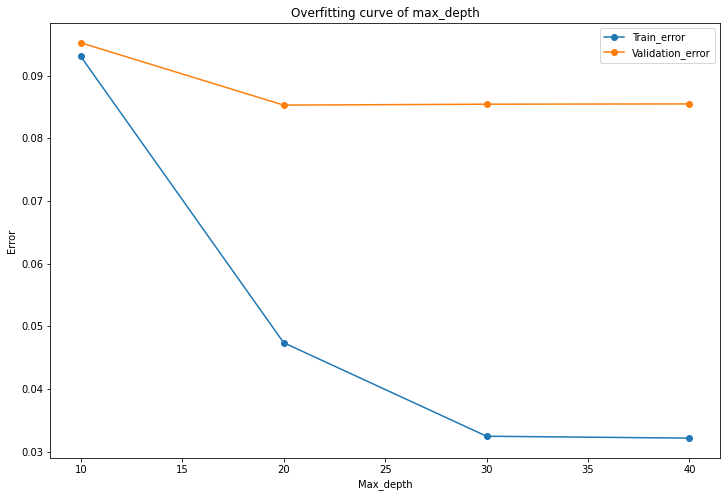

In [121]:
plt.figure(figsize=(12,8))
plt.plot(max_depth.Max_depth,max_depth.Train_error,'o-')
plt.plot(max_depth.Max_depth,max_depth.Validation_error,'o-')
plt.title('Overfitting curve of max_depth')
plt.xlabel('Max_depth')
plt.ylabel('Error')
plt.legend(['Train_error','Validation_error']);

By the above graph the optimal value of n_estimators is 20.

In [105]:
def min_samples_split(n):
  optimal_model = RandomForestRegressor(random_state = 42,n_jobs = - 1,min_samples_split = n,n_estimators =10).fit(train_inputs,train_target)
  optimal_train_pred = optimal_model.predict(train_inputs)
  optimal_val_pred = optimal_model.predict(val_inputs)
  train_error = rmse(optimal_train_pred,train_target)
  val_error = rmse(optimal_val_pred,val_target)
  return {'Min_sample_splits':n,'Train_error':train_error,'Validation_error':val_error} 

In [112]:
%%time
min_sample = pd.DataFrame([min_samples_split(n) for n in range(10,100,10)])

C:\Users\Mohit Bhilwara\AppData\Local\Temp\ipykernel_1000\4262530265.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  optimal_model = RandomForestRegressor(random_state = 42,n_jobs = - 1,min_samples_split = n,n_estimators =10).fit(train_inputs,train_target)
C:\Users\Mohit Bhilwara\AppData\Local\Temp\ipykernel_1000\4262530265.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  optimal_model = RandomForestRegressor(random_state = 42,n_jobs = - 1,min_samples_split = n,n_estimators =10).fit(train_inputs,train_target)
C:\Users\Mohit Bhilwara\AppData\Local\Temp\ipykernel_1000\4262530265.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  optimal_model = RandomFo

CPU times: total: 6min 7s
Wall time: 2min 14s


In [113]:
min_sample

,Min_sample_splits,Train_error,Validation_error
0,10,0.050531,0.088177
1,20,0.060786,0.087334
2,30,0.066523,0.087056
3,40,0.070180,0.087019
4,50,0.072723,0.087057
5,60,0.074704,0.087198
6,70,0.076339,0.087375
7,80,0.077598,0.087525
8,90,0.078681,0.087697


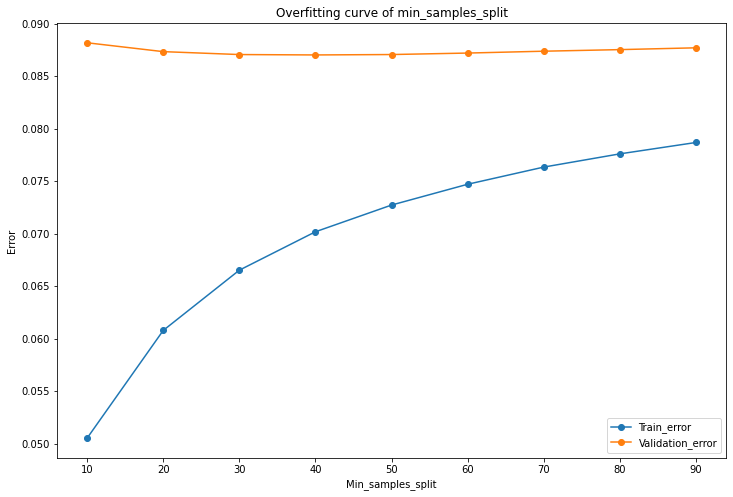

In [120]:
plt.figure(figsize=(12,8))
plt.plot(min_sample.Min_sample_splits,min_sample.Train_error,'o-')
plt.plot(min_sample.Min_sample_splits,min_sample.Validation_error,'o-')
plt.title('Overfitting curve of min_samples_split')
plt.xlabel('Min_samples_split')
plt.ylabel('Error')
plt.legend(['Train_error','Validation_error']);

By the above graph the optimal value of n_estimators is 40.

# Final Hypertuned RandomForest Model
creating `RandomForestRegressor` model using optimal values of above tested parameters 

In [117]:
final_model = RandomForestRegressor(random_state = 42, n_jobs =-1 , n_estimators = 80, max_depth = 20, min_samples_split =40 ).fit(train_inputs,train_target)

C:\Users\Mohit Bhilwara\AppData\Local\Temp\ipykernel_1000\1831963690.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  final_model = RandomForestRegressor(random_state = 42, n_jobs =-1 , n_estimators = 80, max_depth = 20, min_samples_split =40 ).fit(train_inputs,train_target)


In [119]:
train_pred = final_model.predict(train_inputs)
val_pred = final_model.predict(val_inputs)
hyper_error = (rmse(train_pred,train_target),rmse(val_pred,val_target))
print('Decision model error:',decision_error)
print('Base randomForest model error:',random_error)
print('Hypertuned model error:',hyper_error)

Decision model error: (3.850502385100256e-18, 0.12060557044914483)
Base randomForest model error: (0.037909774781402575, 0.08940288299508428)
Hypertuned model error: (0.07010219836190638, 0.08563015201445966)


In [123]:
jovian.commit()

<IPython.core.display.Javascript object>

[jovian] Updating notebook "mbhilwara12/pubg-finish-placement-prediction" on https://jovian.ai/
[jovian] Committed successfully! https://jovian.ai/mbhilwara12/pubg-finish-placement-prediction


'https://jovian.ai/mbhilwara12/pubg-finish-placement-prediction'

# Predicting winPlacePerc in test.csv using random forest model

In [124]:
test_df = pd.read_csv('pubg-finish-placement-prediction/test_V2.csv')

In [125]:
test_df.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints
0,9329eb41e215eb,676b23c24e70d6,45b576ab7daa7f,0,0,51.46,0,0,0,73,...,1500,0,0.0,0,0.0,0,0,588.0,1,0
1,639bd0dcd7bda8,430933124148dd,42a9a0b906c928,0,4,179.10,0,0,2,11,...,1503,2,4669.0,0,0.0,0,0,2017.0,6,0
2,63d5c8ef8dfe91,0b45f5db20ba99,87e7e4477a048e,1,0,23.40,0,0,4,49,...,1565,0,0.0,0,0.0,0,0,787.8,4,0
3,cf5b81422591d1,b7497dbdc77f4a,1b9a94f1af67f1,0,0,65.52,0,0,0,54,...,1465,0,0.0,0,0.0,0,0,1812.0,3,0
4,ee6a295187ba21,6604ce20a1d230,40754a93016066,0,4,330.20,1,2,1,7,...,1480,1,0.0,0,0.0,0,0,2963.0,4,0


In [126]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1934174 entries, 0 to 1934173
Data columns (total 28 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int64  
 4   boosts           int64  
 5   damageDealt      float64
 6   DBNOs            int64  
 7   headshotKills    int64  
 8   heals            int64  
 9   killPlace        int64  
 10  killPoints       int64  
 11  kills            int64  
 12  killStreaks      int64  
 13  longestKill      float64
 14  matchDuration    int64  
 15  matchType        object 
 16  maxPlace         int64  
 17  numGroups        int64  
 18  rankPoints       int64  
 19  revives          int64  
 20  rideDistance     float64
 21  roadKills        int64  
 22  swimDistance     float64
 23  teamKills        int64  
 24  vehicleDestroys  int64  
 25  walkDistance     float64
 26  weaponsAcquired  int64  
 27  winPoints   

In [127]:
test_df.isna().sum()

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
dtype: int64

In [128]:
encoder2 = OneHotEncoder(sparse = False , handle_unknown = 'ignore').fit(test_df[catagorical_col])

C:\Users\Mohit Bhilwara\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [129]:
test_df[encoded_col] = encoder2.transform(test_df[catagorical_col])

In [130]:
test_df.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,matchType_normal-duo,matchType_normal-duo-fpp,matchType_normal-solo,matchType_normal-solo-fpp,matchType_normal-squad,matchType_normal-squad-fpp,matchType_solo,matchType_solo-fpp,matchType_squad,matchType_squad-fpp
0,9329eb41e215eb,676b23c24e70d6,45b576ab7daa7f,0,0,51.46,0,0,0,73,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,639bd0dcd7bda8,430933124148dd,42a9a0b906c928,0,4,179.10,0,0,2,11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,63d5c8ef8dfe91,0b45f5db20ba99,87e7e4477a048e,1,0,23.40,0,0,4,49,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,cf5b81422591d1,b7497dbdc77f4a,1b9a94f1af67f1,0,0,65.52,0,0,0,54,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ee6a295187ba21,6604ce20a1d230,40754a93016066,0,4,330.20,1,2,1,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [131]:
test_df.drop(Id,axis =1,inplace = True)

In [136]:
test_df.drop(['matchType'],axis = 1 , inplace = True)

In [137]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1934174 entries, 0 to 1934173
Data columns (total 40 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   assists                     int64  
 1   boosts                      int64  
 2   damageDealt                 float64
 3   DBNOs                       int64  
 4   headshotKills               int64  
 5   heals                       int64  
 6   killPlace                   int64  
 7   killPoints                  int64  
 8   kills                       int64  
 9   killStreaks                 int64  
 10  longestKill                 float64
 11  matchDuration               int64  
 12  maxPlace                    int64  
 13  numGroups                   int64  
 14  rankPoints                  int64  
 15  revives                     int64  
 16  rideDistance                float64
 17  roadKills                   int64  
 18  swimDistance                float64
 19  teamKills            

In [138]:
X_test = test_df

In [139]:
predictions = final_model.predict(X_test)
predictions

array([0.2167076 , 0.2179853 , 0.2167076 , ..., 0.2167076 , 0.21633847,
       0.21574605])

In [140]:
submission_df = pd.read_csv('pubg-finish-placement-prediction/sample_submission_V2.csv')


In [141]:
submission_df.head()

,Id,winPlacePerc
0,9329eb41e215eb,1
1,639bd0dcd7bda8,1
2,63d5c8ef8dfe91,1
3,cf5b81422591d1,1
4,ee6a295187ba21,1


In [142]:
submission_df['winPlacePerc'] = predictions

In [143]:
submission_df.head()

,Id,winPlacePerc
0,9329eb41e215eb,0.216708
1,639bd0dcd7bda8,0.217985
2,63d5c8ef8dfe91,0.216708
3,cf5b81422591d1,0.216338
4,ee6a295187ba21,0.216708


In [144]:
submission_df.to_csv('submission.csv',index = False)

In [145]:
import jovian
# import joblib


In [147]:
jovian.commit()

<IPython.core.display.Javascript object>

[jovian] Updating notebook "mbhilwara12/pubg-finish-placement-prediction" on https://jovian.ai/
[jovian] Committed successfully! https://jovian.ai/mbhilwara12/pubg-finish-placement-prediction


'https://jovian.ai/mbhilwara12/pubg-finish-placement-prediction'

# References
- Dataset: https://www.kaggle.com/competitions/pubg-finish-placement-prediction
- Opendatsets library: https://github.com/JovianML/opendatasets
- EDA project from scratch: https://www.youtube.com/watch?v=kLDTbavcmd0
- Machine Learning with Python: Zero to GBMs - https://zerotogbms.com